This notebook attempts to perform basic EDA and evaluate linear regression models on to Kaggle dataset https://www.kaggle.com/c/house-prices-advanced-regression-techniques   
Steps:
1. Load the required Libraries
2. Loading the test and train datasets
3. Examine the target variable 'SalePrice' and apply log transformation to overcome the skewness
4. Exploring the numeric and categorical variables and determine the most important ones by looking at the correlations.
5. Impute the missing values based with help from data dictionary and drop the non-relevant (Utilities, Id ) columns
6. Convert the Categorial variables to Ordinal wherever possible
7. Feature Engineering: Try and combine relevant fields and cut the redundant ones. For example, instead of considering each variable alone, create a new variable total bath, total square foot, etc.
8. Transform the data for chosen variables to overcome skewness
9. Drop the variables with co-linearity, ex: Garage Cars and Garage Area: One of them should suffice.
10. Apply one-hot encoding on the remaining categorical variables
11. Apply Ridge and Lasso Regression and predict the sale price on test data. The final submission is the average of the above two prediction results
12. Evaluate the Lasso and Ridge models using test_split_train and cross-validation techniques to calculate RMSE.


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm
from scipy import stats

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
df_train = train = pd.read_csv("/content/train.csv")
sample,features = train.shape[0],train.shape[1]
print(f"Train data contains {sample} rows and {features} columns")
train.head()

Train data contains 1460 rows and 81 columns


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [3]:
df_test = test = pd.read_csv("/content/test.csv")
sample,features = test.shape[0],test.shape[1]
print(f"Test data contains {sample} rows and {features} columns")
test.head()

Test data contains 1459 rows and 80 columns


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


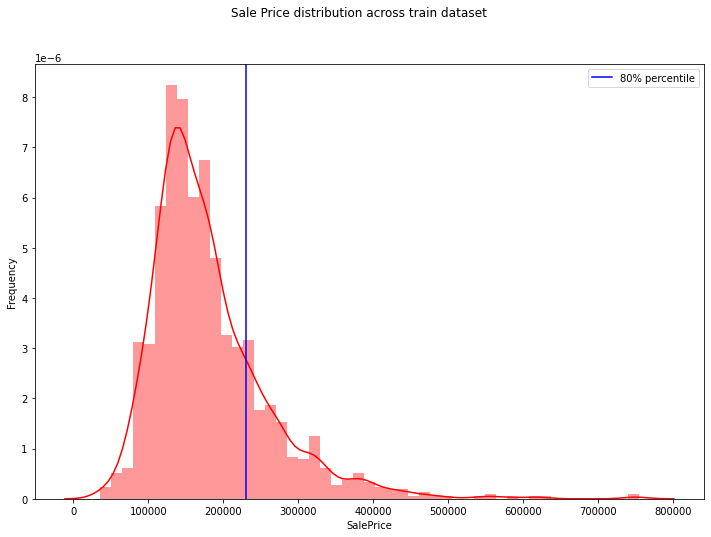

Above Distribution has 1.88 skewness values
Above Distribution has 6.54 kurtosis values


In [4]:
plt.figure(figsize = (12,8))
sns.distplot(train['SalePrice']
                ,color = 'r')
#plt.xlabel("Sale Price distribution across train dataset")
plt.ylabel("Frequency")
skewness = np.round(train['SalePrice'].skew(),2)
kurtosis = np.round(train['SalePrice'].kurt(),2)
plt.axvline(np.percentile(train['SalePrice'],80),color = 'blue',label = "80% percentile")
plt.suptitle(f"Sale Price distribution across train dataset")
plt.legend()
plt.show()

print(f"Above Distribution has {skewness} skewness values")
print(f"Above Distribution has {kurtosis} kurtosis values")

SalePrice features is not normally distributed, and can be clearly interpreted as right skewed as there is long tail in the right of the plot. To check if above features is log normally distributed or not we are going to plot log values of SalePrice feature. If resulted distribution is normally distributed then we can take log(SalePrice) as target variable.

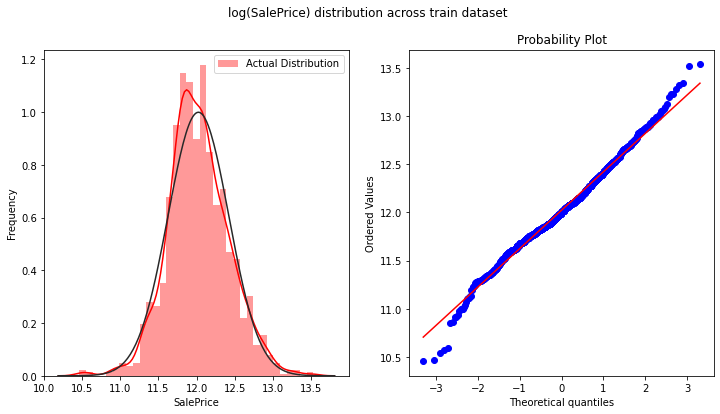

In [5]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
sns.distplot(np.log(train['SalePrice'])
                ,color = 'r',label = "Actual Distribution",fit = norm)
#plt.xlabel("Sale Price distribution across train dataset")
plt.ylabel("Frequency")
plt.suptitle(f"log(SalePrice) distribution across train dataset")
plt.legend()

plt.subplot(1,2,2)
stats.probplot(np.log(train['SalePrice']),plot = plt)

plt.show()

In [6]:
df = pd.concat([train,test])
df.shape

(2919, 81)

Finding the top correlation features



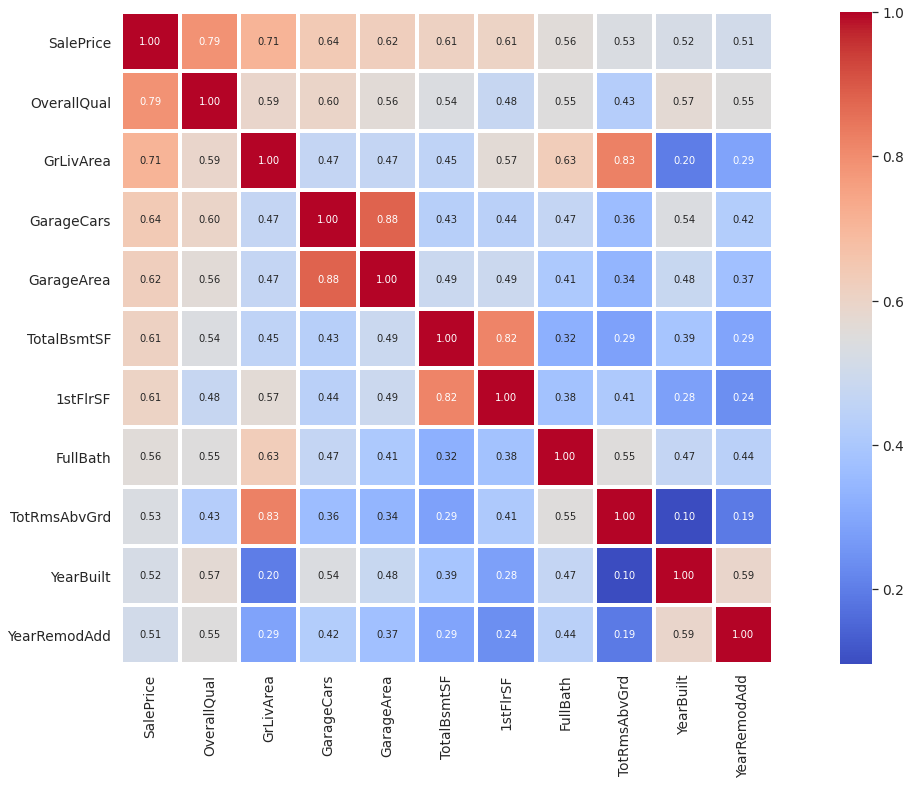

In [7]:
corr = df[df.columns[1:]].corr()['SalePrice'][:]
corr = corr[(corr >= 0.5)].sort_values(ascending=False)
plt.figure(figsize=(24,12))
topcorrcols = corr.index
sns.set(font_scale = 1.25)
sns.heatmap(train[topcorrcols].corr(), annot=True,linewidths=3,cmap='coolwarm',square=True,fmt='.2f',annot_kws={'size': 10})

We can see that multicollinearity between different features. For example: the correlation between GarageCars and GarageArea is very high (0.88), and both have similar (high) correlations with SalePrice.

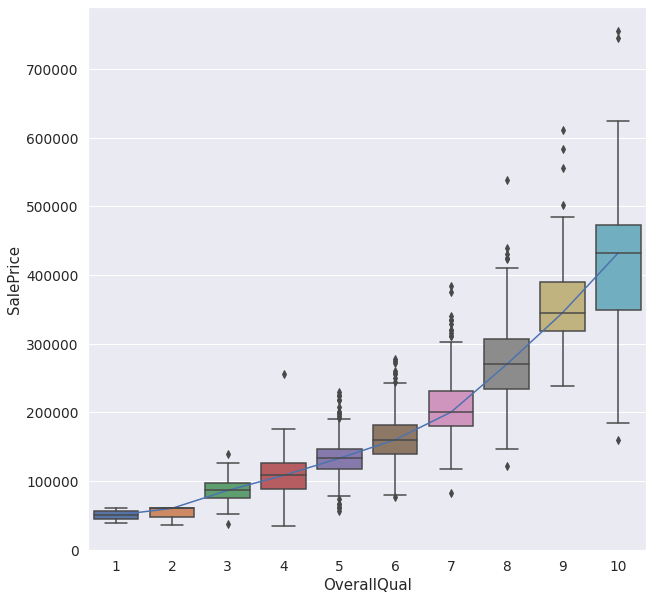

In [8]:
#Analyze the Categorical Variables

#box plot overallqual/saleprice
median =  train.groupby('OverallQual')['SalePrice'].median()
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(10, 10))
ax.plot(median.values)
fig = sns.boxplot(x=var, y="SalePrice", data=data)


As expected, the sale price increases for a better quality house. Next Step is to fill in all the missing values

In [9]:
Quality = {'None': 0, 'Po': 1, 'Fa' : 2, 'TA' : 3, 'Gd' : 4, 'Ex' : 5}

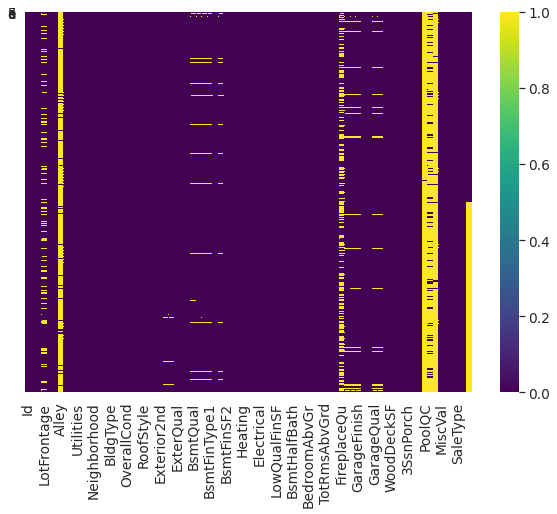

In [10]:
plt.figure(figsize=(10,7))
sns.heatmap(df.isnull(),yticklabels='False',cmap='viridis')

In [11]:
#Convert certain numeric values to categories
def convert_dtype(data):
    data['MSSubClass'] = data['MSSubClass'].astype(str)
    data['YrSold'] = data['YrSold'].astype(str)
    data['MoSold'] = data['MoSold'].astype(str)
    return(data)
df = convert_dtype(df)
print(df.shape)

(2919, 81)


In [12]:
#Fill the missing values with either 0 or None As per the data description

#Pool Variables , Try to fit in the Categorial variables as Ordinal, Nominal Continous etc

df['PoolQC'] = df['PoolQC'].fillna('None')
df['PoolQC'] = df['PoolQC'].map(Quality)

#Check if there is pool area and Pool QC is still 0.
#df_train['PoolQC'].value_counts()
df[(df['PoolArea'] > 0) & (df['PoolQC'] == 0)][['PoolArea','PoolQC','OverallQual']]


#In the test training set we have certain values with PoolQC = , even with pool area. Try to match up this value with 
#OverallQuality
df.at[960,'PoolQC'] = 2
df.at[1043,'PoolQC'] = 3
df.at[1139,'PoolQC'] = 2


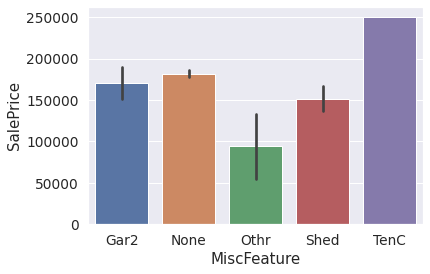

In [13]:
#Miscellaneous Features - Based on the barchart the values do not seem to be Ordinal
df['MiscFeature'].value_counts()
#Replace the NA's with None - Indicating no mis features. 
df['MiscFeature'] = df['MiscFeature'].fillna('None')
df['MiscFeature'] = df['MiscFeature'].astype('category')
sns.barplot(x='MiscFeature',y='SalePrice',data=df[df['SalePrice'] != np.nan])


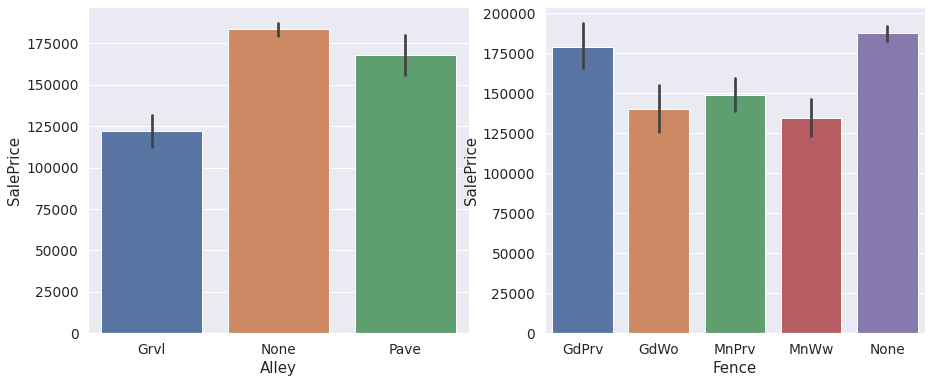

In [14]:
#Alley,Fence

#Replace the NA's with None - Indicating no mis features. 
df['Alley'] = df['Alley'].fillna('None')
df['Alley'] = df['Alley'].astype('category')
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.barplot(x='Alley',y='SalePrice',data=df[df['SalePrice'].notnull()])

df['Fence'] = df['Fence'].fillna('None')
df['Fence'] = df['Fence'].astype('category')
plt.subplot(1,2,2)
sns.barplot(x='Fence',y='SalePrice',data=df[df['SalePrice'].notnull()])

In [15]:
#Number of FirePlaces, Fire Place Quality
df[['Fireplaces','FireplaceQu']].isnull().sum()
len(df[df['Fireplaces'] == 0])
#We can replace the values FireplaceQu with None and use the above Quality Matix to convert the data to ordinal
df['FireplaceQu'] = df['FireplaceQu'].fillna('None')
df['FireplaceQu'] = df['FireplaceQu'].map(Quality)


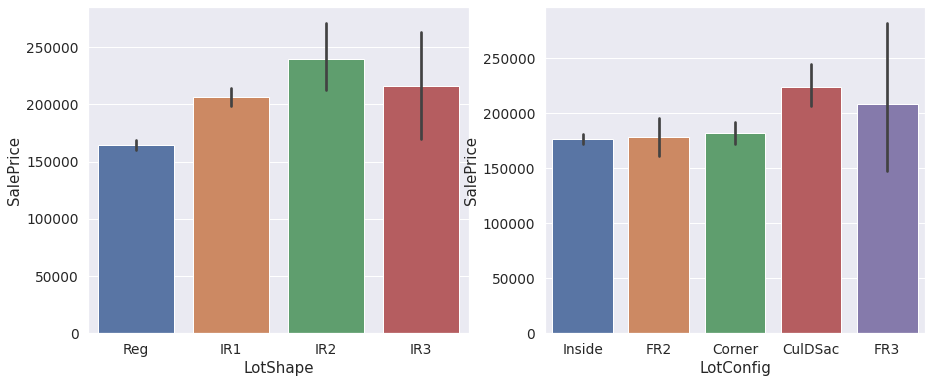

In [16]:
df["LotFrontage"] = df.groupby(by="Neighborhood")["LotFrontage"].transform(lambda x: x.fillna(x.median()))

plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.barplot(x='LotShape',y='SalePrice',data=df[df['SalePrice'].notnull()],estimator=np.mean)
plt.subplot(1,2,2)
sns.barplot(x='LotConfig',y='SalePrice',data=df[df['SalePrice'].notnull()],estimator=np.mean)
#Lot Shape - Convert Lot Shape into Ordinal
df['LotShape'] = df['LotShape'].map({'IR3':0,'IR2':1,'IR1':2,'Reg':3})
df['LotConfig'] = df['LotConfig'].astype('category')


In [17]:
#Garage Variables : There are seven garage variables all togerther
GarageCols = ['GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageArea','GarageQual','GarageCond']
df[GarageCols].isnull().sum()

for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    df[col] = df[col].fillna('None')
for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    df[col] = df[col].fillna(0)

#Form the Ordinal and Categorical Variables
#1. GarageType 
df['GarageType'] = df['GarageType'].astype('category')
df['GarageFinish'] = df['GarageFinish'].map({'None':0,'Unf':1,'RFn':2,'Fin':3})
df['GarageQual'] = df['GarageQual'].map(Quality)
df['GarageCond'] = df['GarageCond'].map(Quality)

In [18]:
#Basement Variables : There are 11 Basement Variables
BasementCols = ['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'\
                ,'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
df[BasementCols].isnull().sum()

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    df[col] = df[col].fillna(0)
for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    df[col] = df[col].fillna('None')

df['BsmtQual'] = df['BsmtQual'].map(Quality)
df['BsmtCond'] = df['BsmtCond'].map(Quality)
df['BsmtExposure'] = df['BsmtExposure'].map({'None':0,'No':1,'Mn':2,'Av':3,'Gd':4})
df['BsmtFinType1'] = df['BsmtFinType1'].map({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})
df['BsmtFinType2'] = df['BsmtFinType2'].map({'None':0, 'Unf':1, 'LwQ':2, 'Rec':3, 'BLQ':4, 'ALQ':5, 'GLQ':6})

In [19]:
#Mansory Variables

MansoryCols = ['MasVnrType', 'MasVnrArea', 'MSZoning' ]
df[MansoryCols].isnull().sum()
pd.crosstab(df['MasVnrType'],df['MSZoning'])

MSZoning,C (all),FV,RH,RL,RM
MasVnrType,,,,,
BrkCmn,0,0,0,24,1
BrkFace,0,32,4,770,73
None,25,80,22,1247,364
Stone,0,20,0,207,22


In [20]:
(df[(df['MasVnrType'].isnull()) & (df['MasVnrArea'].notnull())])[['MasVnrType','MasVnrArea','MSZoning']]
#Replace the above value with BrkFace
df.at[1150,'MasVnrType'] = 'BrkFace'
df["MasVnrType"] = df["MasVnrType"].fillna("None")
df["MasVnrArea"] = df["MasVnrArea"].fillna(0)
df['MSZoning'] = df['MSZoning'].fillna(df['MSZoning'].mode()[0])
df['MSZoning'] = df['MSZoning'].astype('category')
df['MSZoning'].value_counts()
Masonry = {'None':0, 'BrkCmn':0, 'BrkFace':1, 'Stone':2} #Calculated based on the median of the sale prices
df["MasVnrType"] = df['MasVnrType'].map(Masonry)

In [21]:
#Kitchen Variables
#df['KitchenQual'] = df.groupby(by = 'OverallQual')['KitchenQual'].transform(lambda x: x.fillna(x.mode()))
df['KitchenQual'] = df['KitchenQual'].fillna('TA')
df['KitchenQual'] = df['KitchenQual'].map(Quality)

In [22]:
#Utilities
df['Utilities'].value_counts()
#Except for 2 missing values in the test training set all the column has same value 'AllPub'. Imputing the data with same value
#does not provide any additional benefit and will not be of any use for prediction as this would be a constant value.
#We can safely drop this value

AllPub    2916
NoSeWa       1
Name: Utilities, dtype: int64

In [23]:
#Home Functionality
df['Functional'].isnull().sum()
df['Functional'].value_counts()
#Imputing the missing values with mode
df["Functional"] = df["Functional"].fillna(df['Functional'].mode()[0])
#Based on the description, this can be considered an ordinal parameter
df['Functional'] = df['Functional'].map({'Sal':0, 'Sev':1, 'Maj2':2, 'Maj1':3, 'Mod':4, 'Min2':5, 'Min1':6, 'Typ':7})

In [24]:
#Exterior Variables
df['Exterior1st'] = df['Exterior1st'].fillna(df['Exterior1st'].mode()[0])
df['Exterior2nd'] = df['Exterior2nd'].fillna(df['Exterior2nd'].mode()[0])
df['Exterior1st'] = df['Exterior1st'].astype('category')
df['Exterior2nd'] = df['Exterior1st'].astype('category')

df['ExterQual'] = df['ExterQual'].map(Quality)
df['ExterCond'] = df['ExterCond'].map(Quality)

In [25]:
#Electrical System
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])
df['Electrical'] = df['Electrical'].astype('category')

#SaleType
df['SaleType'] = df['SaleType'].fillna(df['SaleType'].mode()[0])
df['SaleType'] = df['SaleType'].astype('category')

#SaleCondition
df['SaleCondition'] = df['SaleCondition'].astype('category')


In [26]:
df['Foundation'] = df['Foundation'].astype('category')
df.Foundation.value_counts()

#Heating
df['Heating'] = df['Heating'].astype('category')
df['HeatingQC'] = df['HeatingQC'].map(Quality)
df['CentralAir'] = df['CentralAir'].map({'N':0,'Y':1})

In [27]:
#Roof, LandContour(Flatness of property), landslope, Building Type,House Style, Neighborhood, condition1, condition2

df['RoofStyle'] = df['RoofStyle'].astype('category')
df['RoofMatl'] = df['RoofMatl'].astype('category')
df['LandContour'] = df['LandContour'].astype('category')
df['LandSlope'] = df['LandSlope'].astype('category')
df['BldgType'] = df['BldgType'].astype('category')
df['HouseStyle'] = df['HouseStyle'].astype('category')
df['Neighborhood'] = df['Neighborhood'].astype('category')
df['Condition1'] = df['Condition1'].astype('category')
df['Condition2'] = df['Condition2'].astype('category')

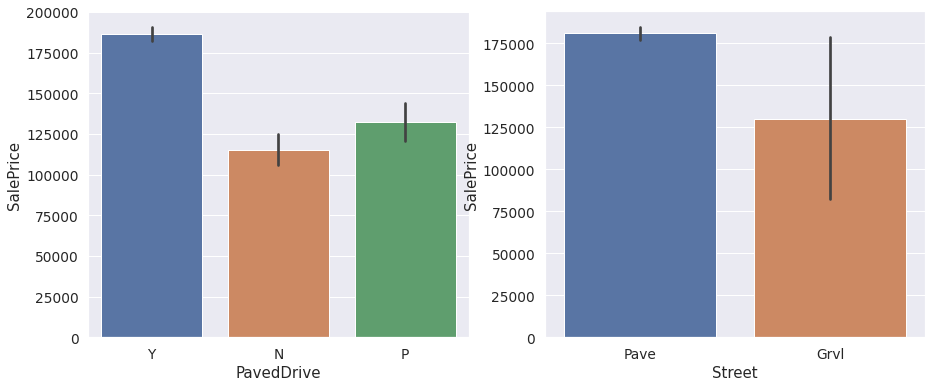

In [28]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
sns.barplot(x='PavedDrive',y='SalePrice',data=df[df['SalePrice'].notnull()],estimator=np.mean)
plt.subplot(1,2,2)
sns.barplot(x='Street',y='SalePrice',data=df[df['SalePrice'].notnull()],estimator=np.mean)

df['PavedDrive'] = df['PavedDrive'].map({'N':0,'P':1,'Y':2})
df['Street'] = df['Street'].map({'Grvl':0,'Pave':1})

In [29]:
droplist = ['Id','Utilities']
df.drop(columns=droplist,axis='columns', inplace=True)

In [30]:
val = df.isnull().sum() 
val[val > 0]

SalePrice    1459
dtype: int64

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


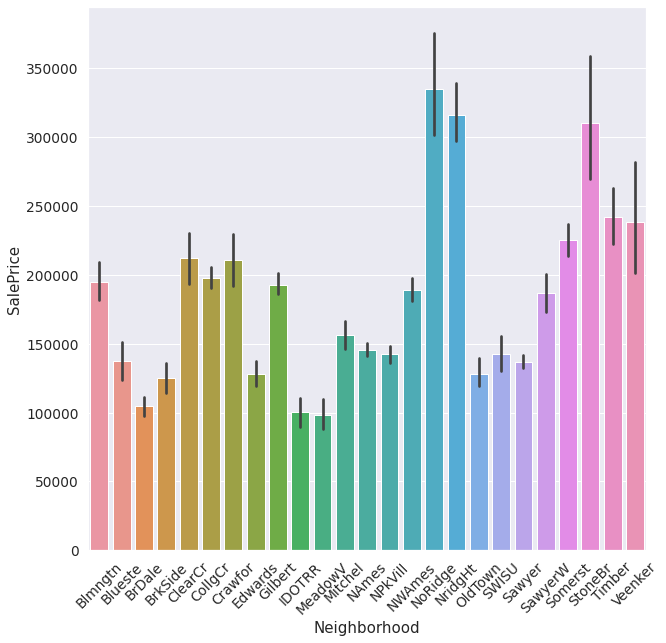

In [31]:
#Neighborhood Binning
df_tmp = df[df['SalePrice'].notnull()]
df_tmp.sort_values(by=['SalePrice'],inplace=True,ascending=False)
df_tmp = df_tmp.reset_index(drop=True)
plt.figure(figsize = (10,10))
g = sns.barplot(x='Neighborhood',y='SalePrice',data=df_tmp,estimator=np.mean)


for item in g.get_xticklabels():
    item.set_rotation(45)

In [32]:
df_sp_median = df_tmp.groupby(by='Neighborhood')[['Neighborhood','SalePrice']].agg(['median','mean'])
df_sp_median.sort_values([('SalePrice','median')]).head(5)

SalePrice               
                median           mean
Neighborhood                         
MeadowV        88000.0   98576.470588
IDOTRR        103000.0  100123.783784
BrDale        106000.0  104493.750000
OldTown       119000.0  128225.300885
Edwards       121750.0  128219.700000

In [33]:
list1  = ['StoneBr', 'NridgHt', 'NoRidge']
list2 = ['MeadowV', 'IDOTRR', 'BrDale']
df['NeighborhoodBin'] = [ 2 if item in list1 else 0 if item in list2  else 1 for item in df['Neighborhood']]


#Remove Neighborhood
droplist = ['Neighborhood']
df.drop(droplist,axis=1,inplace=True)

Skewness/Feature Engineering

Above Distribution has 1.27 skewness values
Above Distribution has 4.12 kurtosis values


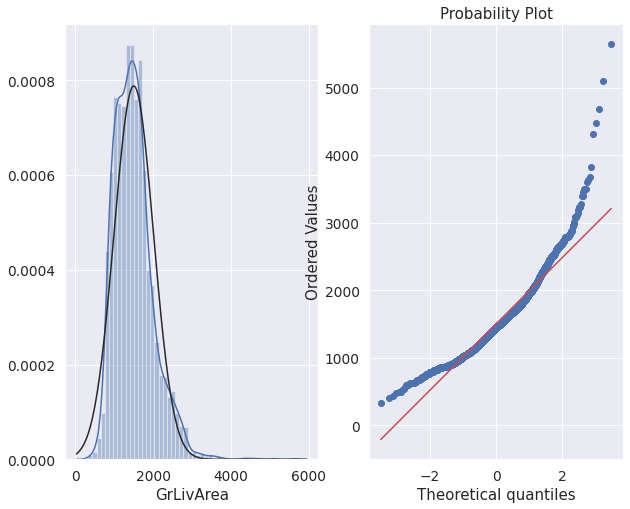

In [34]:
#Check for the factors with high correlation to sales price
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.distplot(df['GrLivArea'], fit=norm);
plt.subplot(1,2,2)
res = stats.probplot(df['GrLivArea'], plot=plt)
skewness = np.round(df['GrLivArea'].skew(),2)
kurtosis = np.round(df['GrLivArea'].kurt(),2)

print(f"Above Distribution has {skewness} skewness values")
print(f"Above Distribution has {kurtosis} kurtosis values")

Above Distribution has 0.01 skewness values
Above Distribution has 0.21 kurtosis values


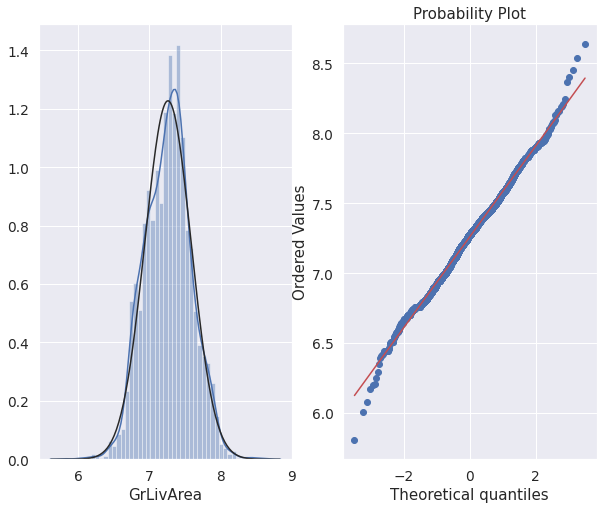

In [35]:
df['GrLivArea'] = np.log(df['GrLivArea'])
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.distplot(df['GrLivArea'], fit=norm);
plt.subplot(1,2,2)
res = stats.probplot(df['GrLivArea'], plot=plt)
skewness = np.round(df['GrLivArea'].skew(),2)
kurtosis = np.round(df['GrLivArea'].kurt(),2)

print(f"Above Distribution has {skewness} skewness values")
print(f"Above Distribution has {kurtosis} kurtosis values")

In [36]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
df['HasBsmt'] = pd.Series(len(df['TotalBsmtSF']), index=df.index)
df['HasBsmt'] = 0 
df.loc[df['TotalBsmtSF']>0,'HasBsmt'] = 1


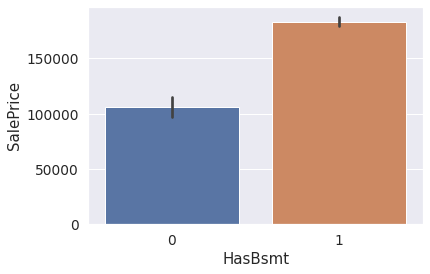

In [37]:
sns.barplot(x='HasBsmt',y='SalePrice',data=df[df['SalePrice'].notnull()],estimator=np.mean)

Above Distribution has 1.51 skewness values
Above Distribution has 9.79 kurtosis values


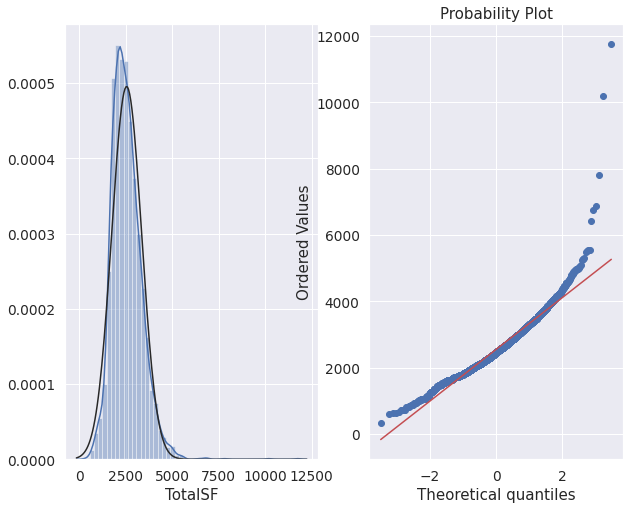

In [38]:
#create column for new variable : Total Square Feet
df['TotalSF'] = df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF']
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.distplot(df['TotalSF'], fit=norm);
plt.subplot(1,2,2)
res = stats.probplot(df['TotalSF'], plot=plt)
skewness = np.round(df['TotalSF'].skew(),2)
kurtosis = np.round(df['TotalSF'].kurt(),2)

print(f"Above Distribution has {skewness} skewness values")
print(f"Above Distribution has {kurtosis} kurtosis values")
droplist = ['TotalBsmtSF','1stFlrSF','2ndFlrSF']
df.drop(droplist,axis=1,inplace=True)

Above Distribution has -0.37 skewness values
Above Distribution has 1.66 kurtosis values


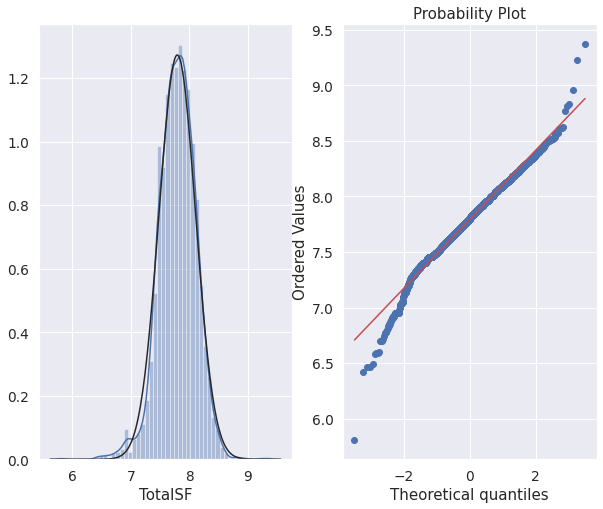

In [39]:
df['TotalSF'] = np.log(df['TotalSF'])
plt.figure(figsize=(10,8))
plt.subplot(1,2,1)
sns.distplot(df['TotalSF'], fit=norm);
plt.subplot(1,2,2)
res = stats.probplot(df['TotalSF'], plot=plt)
skewness = np.round(df['TotalSF'].skew(),2)
kurtosis = np.round(df['TotalSF'].kurt(),2)

print(f"Above Distribution has {skewness} skewness values")
print(f"Above Distribution has {kurtosis} kurtosis values")

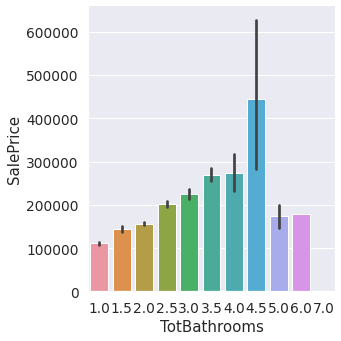

In [40]:
df['TotBathrooms'] = df['FullBath'] + (df['HalfBath']*0.5) + df['BsmtFullBath'] + df['BsmtHalfBath']
g = sns.catplot(x='TotBathrooms', y='SalePrice', data=df,kind='bar')

droplist = ['FullBath','HalfBath','BsmtFullBath','BsmtHalfBath']
df.drop(droplist,axis=1,inplace=True)

In [41]:
#Dropping Highly Corelated Variables

droplist = ['YearRemodAdd', 'GarageYrBlt', 'GarageArea', 'GarageCond', 'TotRmsAbvGrd', 'BsmtFinSF1']
df.drop(droplist,axis=1,inplace=True)

In [42]:
df.shape

(2919, 69)

In [43]:
df['MSSubClass'].astype('category')

0        60
1        20
2        60
3        70
4        60
       ... 
1454    160
1455    160
1456     20
1457     85
1458     60
Name: MSSubClass, Length: 2919, dtype: category
Categories (16, object): [120, 150, 160, 180, ..., 75, 80, 85, 90]

In [44]:
catvar = df.select_dtypes(include=['category']).columns.tolist()
def cat_onehotencoder(df_concat):
    df_temp = df_concat
    for col in df_temp:
        if df_temp[col].dtype.name == 'category':
            df1 = pd.get_dummies(df_concat[col], drop_first = True)
            df_concat.drop([col], axis = 1, inplace = True)
            
            df_concat = pd.concat([df_concat,df1], axis = 1)
    return df_concat



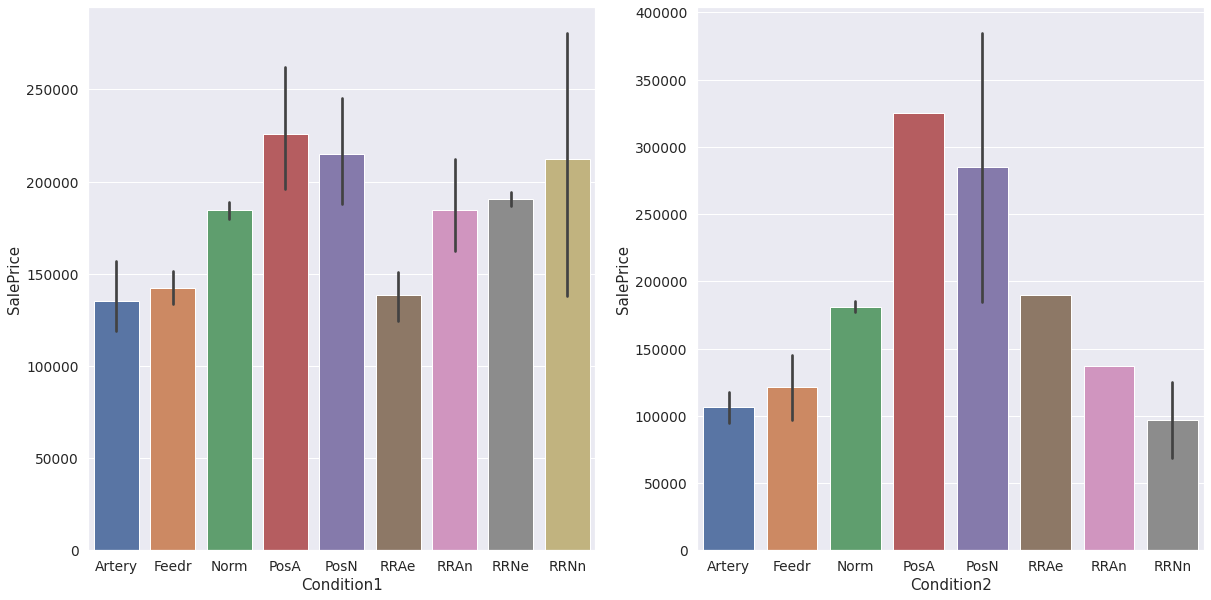

In [45]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.barplot(x='Condition1',y='SalePrice',data=df[df['SalePrice'].notnull()],estimator=np.mean)
plt.subplot(1,2,2)
sns.barplot(x='Condition2',y='SalePrice',data=df[df['SalePrice'].notnull()],estimator=np.mean)

In [46]:
df = cat_onehotencoder(df)

Build a model

In [47]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import mean_squared_error
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

In [48]:
#Create the log variable for SalePrice

df['SalePrice'] = np.log1p(df['SalePrice'])

#Split Back the Test and Training DataSets
X_train = df[df['SalePrice'].notnull()]
X_test = df[df['SalePrice'].isnull()]
y_train = X_train.SalePrice.values
droplist = ['SalePrice']
X_train = X_train.drop(droplist,axis=1)
X_test.drop(droplist,axis=1,inplace=True)


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [49]:
print("All  ", df.shape)
print('Train: ',X_train.shape)
print('Test:' ,X_test.shape)

All   (2919, 170)
Train:  (1460, 169)
Test: (1459, 169)


In [50]:
"Model Using Lasso"
regr = Lasso(alpha=0.0005, max_iter=50000)
regr.fit(X_train, y_train)

y_pred_lasso = regr.predict(X_test)

In [51]:
"Model Using Ridge"
ridge = Ridge()
param_dist = {'alpha':[1e-5,9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5,10,12,15,20,30,50],
              'solver':['auto','svd','lsqr','cholesky','saga']}

clf = GridSearchCV(ridge,
                   param_grid=param_dist,
                   cv=5,
                   return_train_score=True,
                   scoring = 'neg_mean_squared_error')

clf.fit(X_train,y_train)
ridge = clf.best_estimator_ 
ridge.fit(X_train,y_train)
y_pred_ridge = ridge.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.49524e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.88573e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.06405e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=7.44521e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=8.49524e-17): result may not be accurate.
  overwrite_a=True).T
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_ridge.py:148: LinAl

In [52]:
final_price =  np.expm1(( y_pred_lasso + y_pred_ridge ) / 2)
pred_df = pd.DataFrame(final_price, index=df_test["Id"], columns=["SalePrice"])
pred_df.to_csv('Submission_1.csv', header=True, index_label='Id')

In [53]:
result = pd.read_csv("/content/Submission_1.csv")
result.sort_values(['SalePrice'],ascending=False)

,Id,SalePrice
1089,2550,706323.505133
1222,2683,509444.981103
1168,2629,506913.648173
514,1975,497554.783154
834,2295,490459.093675
...,...,...
638,2099,53510.472428
1118,2579,51468.850784
362,1823,49984.756091
387,1848,46537.117597


In [54]:
output_all = pd.DataFrame(
    {'Mean': final_price,
     'Lasso': np.expm1(y_pred_lasso),
     'Reg': np.expm1(y_pred_ridge)
    })
output_all.head()

,Mean,Lasso,Reg
0,108174.453406,106779.759849,109587.363448
1,161286.550492,159843.311907,162742.820116
2,176978.647988,177506.575951,176452.290144
3,199144.846685,200208.340988,198087.001569
4,201966.516785,203043.560955,200895.185765


In [55]:
#Calculate RMSE for Ridge and Lasso
from sklearn.model_selection import train_test_split

X_trainr, X_testr, y_trainr, y_testr = train_test_split(X_train,y_train,test_size=0.30)
ridge = Ridge(alpha=0.1, normalize=True)
ridge.fit(X_trainr,y_trainr)
y_predr = ridge.predict(X_testr)

from sklearn.metrics import mean_squared_error
mean = mean_squared_error(y_testr, y_predr) 
rmse = np.sqrt(mean_squared_error(y_testr,y_predr))

print("Ridge RMSE : ", rmse)

Ridge RMSE :  0.1524884057303557


In [56]:
lasso = Lasso(alpha=0.1, normalize=True)
lasso.fit(X_trainr,y_trainr)
y_predl = lasso.predict(X_testr)

from sklearn.metrics import mean_squared_error
mean = mean_squared_error(y_testr, y_predl) 
rmse = np.sqrt(mean_squared_error(y_testr,y_predl))

print("Lasso RMSE (Alpha = 0.1) : ", rmse)

Lasso RMSE (Alpha = 0.1) :  0.4055942550592873


In [57]:
lasso = Lasso(alpha=0.0005, normalize=True)
lasso.fit(X_trainr,y_trainr)
y_predl = lasso.predict(X_testr)

from sklearn.metrics import mean_squared_error
mean = mean_squared_error(y_testr, y_predl) 
rmse = np.sqrt(mean_squared_error(y_testr,y_predl))

print("Lasso RMSE (Alpha = 0.0005) : ", rmse)

Lasso RMSE (Alpha = 0.0005) :  0.1554947676613543


In [58]:
#Using Cross Validation 
#We pass the entire data and using 10 fold validation
from sklearn.model_selection import cross_val_score
#reusing lasso from above where alpha = 0.0005
scores = cross_val_score(lasso,X_train,y_train, scoring = 'neg_mean_squared_error', cv=10)
lasso_rsme_scores = np.sqrt(-scores)

def display_scores(scores):
  print("Scores: ", scores)
  print("Mean: ", scores.mean())
  print("Standard Deviation: ", scores.std())

display_scores(lasso_rsme_scores)





Scores:  [0.13655817 0.12342383 0.1351558  0.1649417  0.16518755 0.12431437
 0.13130411 0.12513067 0.16887523 0.1345327 ]
Mean:  0.1409424130551161
Standard Deviation:  0.01721663814217915


In [59]:
#Repeating the above for Ridge
scores = cross_val_score(ridge,X_train,y_train, scoring = 'neg_mean_squared_error', cv=10)
ridge_rsme_scores = np.sqrt(-scores)
display_scores(ridge_rsme_scores)

Scores:  [0.13216834 0.11282613 0.12433225 0.15877375 0.14115847 0.12984065
 0.13000511 0.10951231 0.1761446  0.125365  ]
Mean:  0.1340126616492213
Standard Deviation:  0.019219185384147616
